In [8]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_pickle('../data/interim/holdout_lgbm.pck')

df_train.columns
sc = accuracy_score(df_train['label'],df_train['pred'])


0.9605

/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

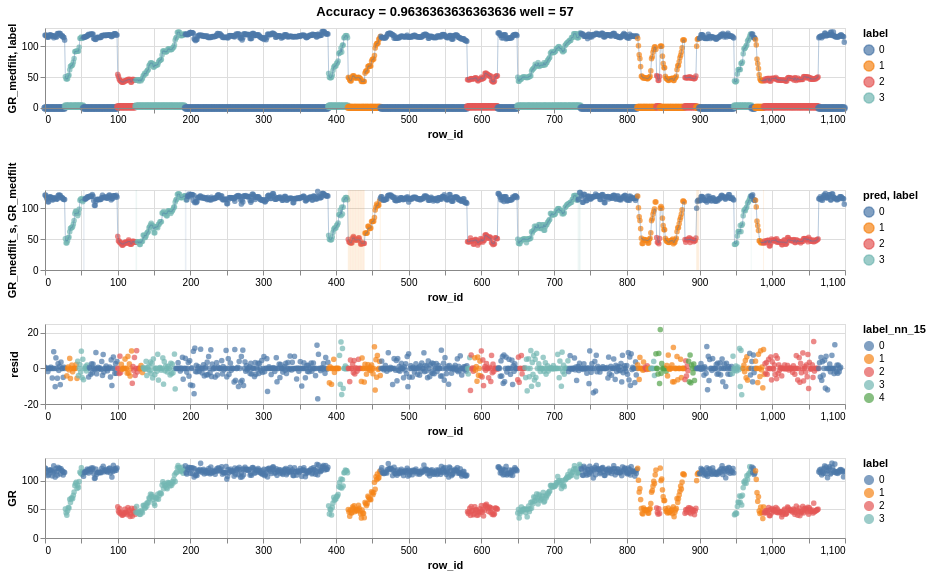

In [20]:
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
#well_ids = 80
#well_ids = 64
#well_ids = 80
well_ids  = np.random.randint(0,100,1)[0]
#well_ids = 50


df_sub = df_train[df_train['well_id'] == well_ids]

df_sub['gr_medfilt_'] = medfilt(df_sub['GR'],3)
df_sub['grdiff'] =df_sub['gr_medfilt_']/medfilt(df_sub['GR'],3)
df_sub['resid'] = df_sub['GR'] - df_sub['gr_medfilt_']

cols = ['GR_medfilt','row_id','well_id','label','pred','label_nn_15','GR_medfilt_corr_parabolic','GR','gr_medfilt_',"grdiff","GR_medfilt_s","resid"]
sc = accuracy_score(df_sub['label'],df_sub['pred'])
title= f'Accuracy = {sc} well = {well_ids}'
df_sub_rules = df_sub[df_sub['label'] !=  df_sub['pred']]
ch_rules = alt.Chart(df_sub_rules,height=80,width=800).encode(x='row_id',color='label:N').mark_rule(size=1,opacity=0.1)

ch_gr = alt.Chart(df_sub[cols],height=80,width=800,title=title).encode(x='row_id',y='GR_medfilt',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_grp = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR_medfilt_s',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_grp_nn = alt.Chart(df_sub[cols].dropna(),height=80,width=800).encode(x='row_id',y='resid',order='row_id',color='label_nn_15:N').mark_point(size=30,filled=True).interactive()

ch_grp_l = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR_medfilt',order='row_id').mark_line(size=0.4)
ch_block = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True).interactive()

((ch_gr + ch_lab+ch_grp_l ) & (ch_grp+ch_grp_l+ch_rules) & (ch_grp_nn)  & ch_block  ).resolve_scale(color='independent',y='independent')


In [ ]:
df_train['grdiff'] = df_train['GR'].diff().abs()
alt.Chart(data=df_train.sample(2000)).encode(x=alt.X('grdiff',bin=alt.Bin(maxbins=100)),y='count()').mark_bar()

In [ ]:
scores = []
for w in df_train['well_id'].unique():
    cols = ['GR_medfilt','row_id','well_id','label','pred','label_nn_30','GR_medfilt_corr_parabolic']
    df_sub = df_train[df_train['well_id'] == w][cols].dropna()
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
scores = np.array(scores)
scores.sort()
(scores> 0.97).sum()

# Test UMAP

In [ ]:
import umap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data = df_train[df_train['well_id']<20].drop(columns=['well_id','label','row_id'])

data = data.fillna(np.nanmean(data))
target =df_train[df_train['well_id']<20]['label']

embedding = make_pipeline(StandardScaler(),umap.UMAP(n_neighbors=45,n_epochs=100)).fit_transform(data,y=target)
#embedding = make_pipeline(StandardScaler(),PCA(2)).fit_transform(data,y=target)


In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.9, c=target, cmap='Accent', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(4))
#cbar.set_ticklabels(classes)
plt.title('UMAP using Labels');

In [ ]:
def make_parabolic(w,amp=50):
    x=[0,w/2,w]
    y=[amp,0,amp]
    p_coef = np.polyfit(x,y,2)
    p=np.poly1d(p_coef)
    x_new = np.arange(w)
    res = p(x_new)
    return res
    
y = make_parabolic(w=50)
tmp = pd.DataFrame({'y':y,'x':np.arange(y.shape[0])})
alt.Chart(tmp).encode(x='x',y='y').mark_point()